# Fully Connected Net

For our least intelligent baseline, just *flatten* all of the layers and train a MLP classifier.

Since the DataLoader has multiple inputs, I think we need to use the module API. 


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In class, they said the network usually saturated with about 3 different hidden layers, so a default architecture I'm trying has hidden dimensions {150, 100, 50}, although these are hyperparams that I could (possibly) tune. I'm also using batchnorm and dropout!

In [3]:
myModel = FCNet()

#### Sanity check
Before training, the validation accuracy should be about 33%

In [4]:
check_accuracy(loader_val, myModel)

Got 9813 / 30000 correct (32.71)


### Next step: Train the net!

For simplicity, just use the adam optimizer!


In [5]:
optimizer = optim.Adam(myModel.parameters(), lr = 0.0001)

In [6]:
np.log(3)

1.0986122886681098

In [7]:
history, myModel = train(loader_train, loader_val, myModel, optimizer, epochs=25, returnBest=True)


Epoch 1/25:
Iteration 0, loss = 1.1144
Got 9700 / 30000 correct (32.33)

Iteration 100, loss = 0.9453
Got 16818 / 30000 correct (56.06)

Iteration 200, loss = 0.8606
Got 19062 / 30000 correct (63.54)

Iteration 300, loss = 0.7778
Got 20014 / 30000 correct (66.71)

Iteration 400, loss = 0.7229
Got 20570 / 30000 correct (68.57)

Iteration 500, loss = 0.6987
Got 20891 / 30000 correct (69.64)

Iteration 600, loss = 0.6887
Got 21098 / 30000 correct (70.33)

Iteration 700, loss = 0.6640
Got 21314 / 30000 correct (71.05)

Got 128013 / 180000 correct (71.12)
Got 21314 / 30000 correct (71.05)

Epoch 2/25:
Iteration 0, loss = 0.6749
Got 21260 / 30000 correct (70.87)

Iteration 100, loss = 0.7052
Got 21493 / 30000 correct (71.64)

Iteration 200, loss = 0.6353
Got 21606 / 30000 correct (72.02)

Iteration 300, loss = 0.5955
Got 21477 / 30000 correct (71.59)

Iteration 400, loss = 0.6783
Got 21750 / 30000 correct (72.50)

Iteration 500, loss = 0.5843
Got 21698 / 30000 correct (72.33)

Iteration 600

Got 22424 / 30000 correct (74.75)

Got 134872 / 180000 correct (74.93)
Got 22470 / 30000 correct (74.90)

Epoch 15/25:
Iteration 0, loss = 0.4433
Got 22468 / 30000 correct (74.89)

Iteration 100, loss = 0.5687
Got 22511 / 30000 correct (75.04)

Iteration 200, loss = 0.4676
Got 22479 / 30000 correct (74.93)

Iteration 300, loss = 0.4208
Got 22457 / 30000 correct (74.86)

Iteration 400, loss = 0.5819
Got 22571 / 30000 correct (75.24)

Iteration 500, loss = 0.4575
Got 22509 / 30000 correct (75.03)

Iteration 600, loss = 0.4631
Got 22499 / 30000 correct (75.00)

Iteration 700, loss = 0.5383
Got 22551 / 30000 correct (75.17)

Got 135335 / 180000 correct (75.19)
Got 22522 / 30000 correct (75.07)

Epoch 16/25:
Iteration 0, loss = 0.4766
Got 22553 / 30000 correct (75.18)

Iteration 100, loss = 0.5122
Got 22503 / 30000 correct (75.01)

Iteration 200, loss = 0.5155
Got 22506 / 30000 correct (75.02)

Iteration 300, loss = 0.4987
Got 22488 / 30000 correct (74.96)

Iteration 400, loss = 0.6369
Got 

In [8]:
check_accuracy(loader_val, myModel)

Got 22634 / 30000 correct (75.45)


## Plot the loss and accuracy curves

- I'm only calculating the accuracies after each epoch, because it was prohibitively slow when I was printing after each iteration.

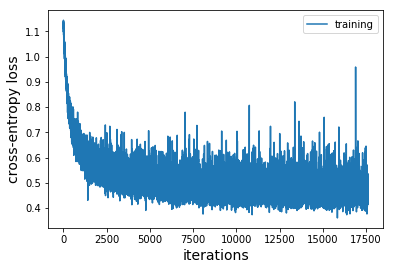

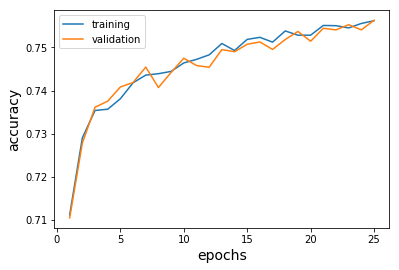

In [9]:
trainingMetrics(history)

## Discriminant plots / ROC Curves

Ok, so for the ROC curves, use the discriminant

$$D_\gamma = \frac{p_\gamma}{p_\pi + p_e}$$

Where $p_i$ corresponds to the output of the softmax node, and this discriminant separates a $\gamma$ signal from a $\pi$ and $e$ background, and we can define similar discriminants for $\pi^+$ or $e^+$ signal.

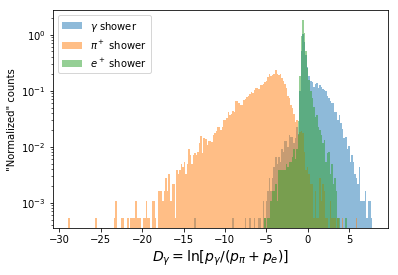

../plottingFcts.py:229: RuntimeWarning: divide by zero encountered in true_divide
  


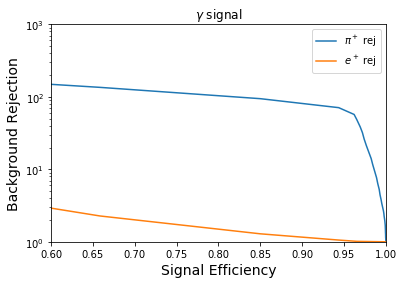

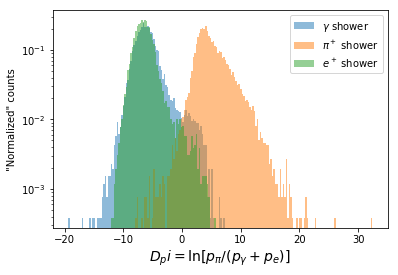

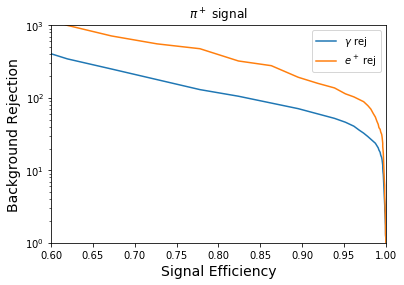

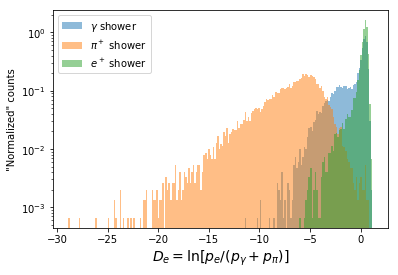

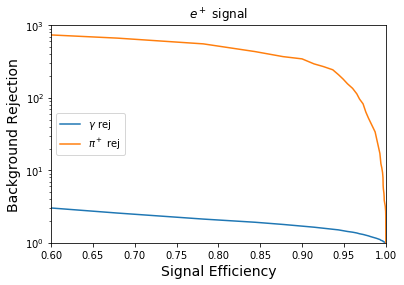

In [10]:
particles = ['gamma','pi','e']

for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(myModel, loader_val, node)
    mTag = '{}-sig_{}'.format(particles[node], myModel.modelName)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal', tag=mTag)
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal', tag=mTag)
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal', tag=mTag)
        

**Notes:**


Also the confusion matrix for these classes?

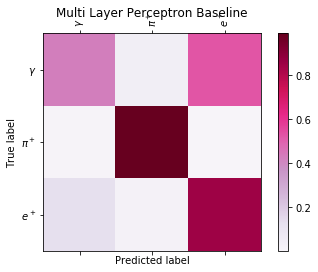

In [11]:
plotConfusion(myModel, loader_val, title="Multi Layer Perceptron Baseline")